#Implementation of Fourier Neural Operators


Darcy Flow PDE:
$\nabla \cdot (a(X)\nabla h(X)) = f(X)$



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft #supports autograd (sorry numpy)
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np

#solve linear pdes
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
"""
End-to-end: generate N Darcy samples, split into train/val/test, batch with DataLoaders,
and return tensors ready for a neural operator (FNO).

This script includes:
  - Darcy FV/FD solver (Dirichlet u=0)
  - Permeability sampler (log-normal GRF)
  - Dataset class that optionally appends (x,y) coordinate channels
  - Train/val/test split + DataLoaders
  - Simple dataset-level normalization helpers

Shapes (default, with coords=True):
  X: [B, Ngrid, Ngrid, 3]   where channels = [a, x, y]
  Y: [B, Ngrid, Ngrid, 1]   pressure field u
"""

import os
from dataclasses import dataclass
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import torch
from torch.utils.data import Dataset, DataLoader


# -----------------------------
# 1) Random field generator for a(x,y)
# -----------------------------
def sample_logk_grf(N: int, length_scale: float = 0.2, sigma: float = 1.0, rng=None) -> np.ndarray:
    """Sample smooth GRF g(x,y) on NxN grid using a simple spectral method."""
    if rng is None:
        rng = np.random.default_rng()

    kx = np.fft.fftfreq(N, d=1.0 / N)
    ky = np.fft.fftfreq(N, d=1.0 / N)
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    K2 = KX**2 + KY**2

    # RBF-like spectrum (smoothness controlled by length_scale)
    S = np.exp(-2.0 * (np.pi**2) * (length_scale**2) * K2)

    z = rng.normal(size=(N, N)) + 1j * rng.normal(size=(N, N))
    g = np.fft.ifft2(z * np.sqrt(S)).real

    # normalize to std=sigma
    g = g - g.mean()
    std = g.std()
    if std > 0:
        g = g * (sigma / std)
    return g


def make_permeability(
    N: int,
    length_scale: float,
    sigma: float,
    a_min: float = 1e-3,
    a_max: float = 1e3,
    rng=None
) -> np.ndarray:
    """Permeability a(x,y) = exp(g(x,y)) clipped to control conditioning."""
    g = sample_logk_grf(N, length_scale=length_scale, sigma=sigma, rng=rng)
    a = np.exp(g)
    return np.clip(a, a_min, a_max)


# -----------------------------
# 2) FV/FD Darcy solver: -div(a grad u) = f, u=0 boundary
# -----------------------------
def solve_darcy_dirichlet(a: np.ndarray, f: float | np.ndarray = 1.0) -> np.ndarray:
    if a.ndim != 2 or a.shape[0] != a.shape[1]:
        raise ValueError("a must be [N, N] square.")
    N = a.shape[0]
    if N < 3:
        raise ValueError("Need N>=3.")

    # RHS
    if np.isscalar(f):
        f_full = np.full((N, N), float(f), dtype=np.float64)
    else:
        f_full = np.asarray(f, dtype=np.float64)
        if f_full.shape != (N, N):
            raise ValueError("f must be scalar or [N,N].")

    Ni = N - 2
    h = 1.0 / (N - 1)
    inv_h2 = 1.0 / (h * h)

    def idx(ii, jj):
        return ii * Ni + jj

    # Harmonic averages on faces (stabilizes heterogeneous media)
    eps = 1e-30
    ax_p = 2 * a[1:-1, 1:-1] * a[2:,   1:-1] / (a[1:-1, 1:-1] + a[2:,   1:-1] + eps)
    ax_m = 2 * a[1:-1, 1:-1] * a[:-2,  1:-1] / (a[1:-1, 1:-1] + a[:-2,  1:-1] + eps)
    ay_p = 2 * a[1:-1, 1:-1] * a[1:-1, 2:  ] / (a[1:-1, 1:-1] + a[1:-1, 2:  ] + eps)
    ay_m = 2 * a[1:-1, 1:-1] * a[1:-1, :-2 ] / (a[1:-1, 1:-1] + a[1:-1, :-2 ] + eps)

    rows, cols, data = [], [], []
    b = f_full[1:-1, 1:-1].reshape(-1).copy()

    for ii in range(Ni):
        for jj in range(Ni):
            p = idx(ii, jj)

            cxp = ax_p[ii, jj] * inv_h2
            cxm = ax_m[ii, jj] * inv_h2
            cyp = ay_p[ii, jj] * inv_h2
            cym = ay_m[ii, jj] * inv_h2

            center = (cxp + cxm + cyp + cym)
            rows.append(p); cols.append(p); data.append(center)

            if ii + 1 < Ni:
                rows.append(p); cols.append(idx(ii + 1, jj)); data.append(-cxp)
            if ii - 1 >= 0:
                rows.append(p); cols.append(idx(ii - 1, jj)); data.append(-cxm)
            if jj + 1 < Ni:
                rows.append(p); cols.append(idx(ii, jj + 1)); data.append(-cyp)
            if jj - 1 >= 0:
                rows.append(p); cols.append(idx(ii, jj - 1)); data.append(-cym)

    A = sp.csr_matrix((data, (rows, cols)), shape=(Ni * Ni, Ni * Ni))
    u_interior = spla.spsolve(A, b)

    u = np.zeros((N, N), dtype=np.float64)
    u[1:-1, 1:-1] = u_interior.reshape(Ni, Ni)
    return u


# -----------------------------
# 3) Generate N samples in memory
# -----------------------------
def generate_samples(
    n_samples: int,
    Ngrid: int,
    length_scale: float = 0.25,
    sigma: float = 1.0,
    f_value: float = 1.0,
    seed: int = 0,
    a_min: float = 1e-3,
    a_max: float = 1e3,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      A: [n_samples, Ngrid, Ngrid]  permeability
      U: [n_samples, Ngrid, Ngrid]  pressure
    """
    rng = np.random.default_rng(seed)
    A = np.zeros((n_samples, Ngrid, Ngrid), dtype=np.float32)
    U = np.zeros((n_samples, Ngrid, Ngrid), dtype=np.float32)

    for i in range(n_samples):
        a = make_permeability(Ngrid, length_scale=length_scale, sigma=sigma, a_min=a_min, a_max=a_max, rng=rng)
        u = solve_darcy_dirichlet(a, f=f_value)
        A[i] = a.astype(np.float32)
        U[i] = u.astype(np.float32)

        if (i + 1) % max(1, n_samples // 10) == 0:
            print(f"Generated {i+1}/{n_samples}")

    return A, U


# -----------------------------
# 4) Dataset + optional coordinate channels
# -----------------------------
class DarcyDataset(Dataset):
    """
    Produces:
      X: [Ngrid, Ngrid, Cin]
      Y: [Ngrid, Ngrid, 1]
    where Cin is 1 (just a) or 3 (a,x,y).
    """
    def __init__(self, A: np.ndarray, U: np.ndarray, coords: bool = True, normalize: bool = True):
        assert A.shape == U.shape and A.ndim == 3
        self.A = A
        self.U = U
        self.coords = coords

        self.Ngrid = A.shape[1]

        # Precompute coords on [0,1]^2 once
        if coords:
            x = np.linspace(0.0, 1.0, self.Ngrid, dtype=np.float32)
            Xg, Yg = np.meshgrid(x, x, indexing="ij")
            self.xy = np.stack([Xg, Yg], axis=-1)  # [Ngrid,Ngrid,2]
        else:
            self.xy = None

        # Dataset-level normalization (common for FNO)
        self.normalize = normalize
        if normalize:
            self.a_mean = float(A.mean())
            self.a_std = float(A.std() + 1e-8)
            self.u_mean = float(U.mean())
            self.u_std = float(U.std() + 1e-8)
        else:
            self.a_mean = self.a_std = self.u_mean = self.u_std = 0.0

    def __len__(self):
        return self.A.shape[0]

    def __getitem__(self, idx: int):
        a = self.A[idx]  # [N,N]
        u = self.U[idx]  # [N,N]

        if self.normalize:
            a = (a - self.a_mean) / self.a_std
            u = (u - self.u_mean) / self.u_std

        # Build X
        a_ch = a[..., None]  # [N,N,1]
        if self.coords:
            x = np.concatenate([a_ch, self.xy], axis=-1)  # [N,N,3]
        else:
            x = a_ch  # [N,N,1]

        y = u[..., None]  # [N,N,1]

        # Convert to torch
        return torch.from_numpy(x), torch.from_numpy(y)


# -----------------------------
# 5) Split + DataLoaders
# -----------------------------
@dataclass
class LoaderPack:
    train: DataLoader
    val: DataLoader
    test: DataLoader
    meta: dict


def make_loaders(
    n_samples: int = 1000,
    Ngrid: int = 64,
    batch_size: int = 16,
    length_scale: float = 0.25,
    sigma: float = 1.0,
    f_value: float = 1.0,
    seed: int = 0,
    coords: bool = True,
    normalize: bool = True,
    split: tuple[float, float, float] = (0.8, 0.1, 0.1),
    num_workers: int = 0,
    pin_memory: bool = True,
) -> LoaderPack:
    """
    Generate data, split, and return DataLoaders.
    """
    assert abs(sum(split) - 1.0) < 1e-6

    A, U = generate_samples(
        n_samples=n_samples,
        Ngrid=Ngrid,
        length_scale=length_scale,
        sigma=sigma,
        f_value=f_value,
        seed=seed,
    )

    # Shuffle indices once
    rng = np.random.default_rng(seed + 999)
    idx = np.arange(n_samples)
    rng.shuffle(idx)

    n_train = int(split[0] * n_samples)
    n_val = int(split[1] * n_samples)
    n_test = n_samples - n_train - n_val

    i_train = idx[:n_train]
    i_val = idx[n_train:n_train + n_val]
    i_test = idx[n_train + n_val:]

    ds_train = DarcyDataset(A[i_train], U[i_train], coords=coords, normalize=normalize)
    # IMPORTANT: use train stats for val/test normalization to avoid leakage
    ds_val = DarcyDataset(A[i_val], U[i_val], coords=coords, normalize=False)
    ds_test = DarcyDataset(A[i_test], U[i_test], coords=coords, normalize=False)

    # Copy normalization stats from train
    if normalize:
        for ds in (ds_val, ds_test):
            ds.normalize = True
            ds.a_mean, ds.a_std = ds_train.a_mean, ds_train.a_std
            ds.u_mean, ds.u_std = ds_train.u_mean, ds_train.u_std

    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory, drop_last=True)
    val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory, drop_last=False)

    meta = {
        "n_samples": n_samples,
        "Ngrid": Ngrid,
        "batch_size": batch_size,
        "coords": coords,
        "normalize": normalize,
        "split": split,
        "train_norm": {
            "a_mean": ds_train.a_mean, "a_std": ds_train.a_std,
            "u_mean": ds_train.u_mean, "u_std": ds_train.u_std
        }
    }

    return LoaderPack(train=train_loader, val=val_loader, test=test_loader, meta=meta)


# -----------------------------
# 6) Example usage (ready for training loop)
# -----------------------------
if __name__ == "__main__":
    loaders = make_loaders(
        n_samples=200,     # increase to e.g. 1000+
        Ngrid=64,
        batch_size=8,
        length_scale=0.25,
        sigma=1.0,
        f_value=1.0,
        seed=0,
        coords=True,
        normalize=True,
        num_workers=0,
    )

    print("Meta:", loaders.meta)

    # Grab one batch and print shapes (what your neural operator will see)
    x, y = next(iter(loaders.train))
    print("Batch X shape:", x.shape)  # [B, N, N, Cin]
    print("Batch Y shape:", y.shape)  # [B, N, N, 1]


Generated 20/200
Generated 40/200
Generated 60/200
Generated 80/200
Generated 100/200
Generated 120/200
Generated 140/200
Generated 160/200
Generated 180/200
Generated 200/200
Meta: {'n_samples': 200, 'Ngrid': 64, 'batch_size': 8, 'coords': True, 'normalize': True, 'split': (0.8, 0.1, 0.1), 'train_norm': {'a_mean': 1.601898431777954, 'a_std': 1.6658763885498047, 'u_mean': 0.03180327266454697, 'u_std': 0.024278763681650162}}
Batch X shape: torch.Size([8, 64, 64, 3])
Batch Y shape: torch.Size([8, 64, 64, 1])


In [3]:
class MLP(nn.Module):
  def __init__(self,input_size,output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, output_size)

  def forward(self, x):
    x = self.fc1(x)
    #x = F.gelu(x)
    return x

class FourierLayer(nn.Module):
  def __init__(self,M,N,C,K_x,K_y):
    super().__init__()
    self.k_x = K_x
    self.k_y = K_y
    self.M = M
    self.N = N

    self.weights_re = nn.Parameter(torch.randn((2,K_x,K_y,C,C))*1.0/C) #[0] is positive k_x, [1] is negative
    self.weights_im = nn.Parameter(torch.randn((2,K_x,K_y,C,C)) *1.0/C)

    self.mlp = MLP(C,C)

  def forward(self,v):
    #shape of v is [B,M,N,C]
    v_hat = torch.fft.rfft2(v,dim=(1,2))
    v_hat_upper = v_hat[:,0:self.k_x,0:self.k_y,:]
    v_hat_lower = v_hat[:,-self.k_x:,0:self.k_y,:]

    W = self.weights_re
    Z = self.weights_im
    a = [v_hat_upper.real,v_hat_lower.real]
    b = [v_hat_upper.imag,v_hat_lower.imag]

    format = "bxyc,xycd->bxyd"
    real_upper = torch.einsum(format,a[0],W[0])-torch.einsum(format,b[0],Z[0])
    im_upper = torch.einsum(format,b[0],W[0])+torch.einsum(format,a[0],Z[0])
    upper = torch.complex(real_upper,im_upper)

    real_lower = torch.einsum(format,a[1],W[1])-torch.einsum(format,b[1],Z[1])
    im_lower = torch.einsum(format,b[1],W[1])+torch.einsum(format,a[1],Z[1])
    lower = torch.complex(real_lower,im_lower)

    out_hat = torch.zeros_like(v_hat) #same shape so we can do ifft
    out_hat[:,0:self.k_x,0:self.k_y,:] = upper
    out_hat[:,-self.k_x:,0:self.k_y,:] = lower

    out = torch.fft.irfft2(out_hat,s=(self.M,self.N),dim=(1,2))


    return F.gelu(out + self.mlp(v))




In [7]:
darcy_in = 3 #(a(x,y),x,y)
darcy_out = 1 #u(x,y)
lift_val = 10
M = 64
N = 64

# lift1 = MLP(darcy_in,lift_val)

# fl1 = FourierLayer(M,N,lift_val,10,10)
# fl2 = FourierLayer(M,N,lift_val,10,10)

# down1 = MLP(lift_val,darcy_out)


class NeuralOperator(nn.Module):
  def __init__(self,darcy_in,darcy_out,lift_val,M,N):
    super().__init__()
    self.lift1 = MLP(darcy_in,lift_val)

    self.fl1 = FourierLayer(M,N,lift_val,10,10)
    self.fl2 = FourierLayer(M,N,lift_val,10,10)

    self.down1 = MLP(lift_val,darcy_out)

  def forward(self,X):
    v = self.lift1(X)
    v_hat = self.fl2(self.fl1(v))
    u_hat = self.down1(v_hat)
    return u_hat

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nop = NeuralOperator(darcy_in,darcy_out,lift_val,M,N)
nop = nop.to(device)

In [9]:
N_epochs = 100
optim = torch.optim.Adam(nop.parameters())
crit = nn.MSELoss()

for epoch in range(N_epochs):
  running_loss = 0
  for x_train,y_train in loaders.train: #iterate to produce x_train of shape (B,M,N,3)
    x_train = x_train.to(device)
    y_train = y_train.to(device)


    u_hat = nop(x_train)


    optim.zero_grad()
    loss = crit(u_hat,y_train)
    loss.backward()
    optim.step()
    running_loss+=loss.item()

  print(f"Epoch {epoch+1} | Training Loss: {running_loss/len(loaders.train)}")

  test_loss = 0
  with torch.no_grad():
    for x_test,y_test in loaders.test:
      x_test = x_test.to(device)
      y_test = y_test.to(device)

      u_hat = nop(x_test)

      loss = crit(u_hat,y_test)
      test_loss+=loss.item()
    print(f"Epoch {epoch+1} | Testing Loss: {test_loss/len(loaders.test)}")

Epoch 1 | Training Loss: 0.9658024996519089
Epoch 1 | Testing Loss: 0.8766184051831564
Epoch 2 | Training Loss: 0.8547966033220291
Epoch 2 | Testing Loss: 0.7754245201746622
Epoch 3 | Training Loss: 0.6472994789481163
Epoch 3 | Testing Loss: 0.5746949315071106
Epoch 4 | Training Loss: 0.3901455238461494
Epoch 4 | Testing Loss: 0.3405025204022725
Epoch 5 | Training Loss: 0.234652279317379
Epoch 5 | Testing Loss: 0.2509244382381439
Epoch 6 | Training Loss: 0.20377362594008447
Epoch 6 | Testing Loss: 0.24589659770329794
Epoch 7 | Training Loss: 0.18292989656329156
Epoch 7 | Testing Loss: 0.23211545248826346
Epoch 8 | Training Loss: 0.16661403328180313
Epoch 8 | Testing Loss: 0.2165303329626719
Epoch 9 | Training Loss: 0.15301053412258625
Epoch 9 | Testing Loss: 0.21551074087619781
Epoch 10 | Training Loss: 0.142812305316329
Epoch 10 | Testing Loss: 0.20216125746568045
Epoch 11 | Training Loss: 0.13529497794806958
Epoch 11 | Testing Loss: 0.1923205554485321
Epoch 12 | Training Loss: 0.1269

In [1]:
x_test,y_test = next(iter(loaders.test))

NameError: name 'loaders' is not defined

In [32]:
x_test = x_test.to(device)

In [33]:
model_pred = nop(x_test)

In [1]:
sns.set_pallete("viridis")
sns.heatmap(model_pred[4,:,:,0].cpu().detach().numpy())

NameError: name 'sns' is not defined

<Axes: >

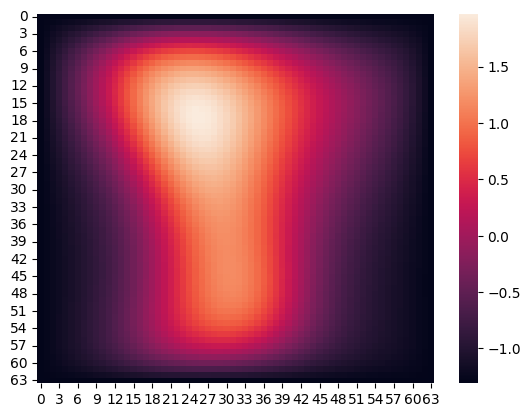

In [40]:
sns.heatmap(y_test[4,:,:,0])